In [1]:
# MSS used for screep capturing
from mss import mss
# Sending Commands to game
import pydirectinput
# Opencv allows frame processing
import cv2
# Transformational framework
import numpy as np
# OCR for game over extraction
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'Tesseract-OCR\tesseract.exe'
# Visualise captured frames
from matplotlib import pyplot as plt
# Bring time for pauses
import time
# Environment
import gymnasium as gym
from gym import Env
from gym.spaces import Box, Discrete
from typing import Optional
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker
# Training algorithms
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [2]:
# Environment
# https://play2048.co 80% screen size on 1920*1080 screen
class WebGame(Env):
    metadata = {"render_modes": ["human", "ansi", "rgb_array"]}
    def __init__(self, render_mode: Optional[str] = None):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1, 600, 600), dtype=np.uint8)
        self.action_space = Discrete(4)
        

        
        self.cap = mss()
        self.game_location = {'top': 372, 'left': 650, 'width': 600, 'height': 600}
        self.done_location = {'top': 580, 'left': 730, 'width': 440, 'height': 100} # Don't zoom in too much on text
        self.win_location = {'top': 580, 'left': 730, 'width': 440, 'height': 140}
        self.reward = 2
        self.render_mode = render_mode
        
    
    # Initial definition of "current action" which is required for previous action
    global current_action 
    current_action = None

    
    def step(self, action):
        if self.render_mode == "human":
            self.render()
        # Action key - 0 = Left 1 = Up 2 = Right 3 = Down
        action_map = {
            0:"left",
            1: "up",
            2: "right",
            3: "down"
        }
        global current_action
        previous_action = current_action
        current_action = action_map[action]
        pydirectinput.press(current_action)
        done, done_cap = self.get_done()
        new_observation = self.get_observation()
        
        # Rewards
        if current_action == previous_action:
            self.reward = -(self.reward * self.reward)
            if self.reward < -300:
                done = True
        else:
            self.reward = 2
        
        info = {}
        win, win_cap = self.get_win()
        if win == True:
            time.sleep(1.5)
            pydirectinput.click(x=850, y=730)
        return new_observation, self.reward, done, info
    
        
    def render(self):
        mode = self.render_mode
        cv2.imshow("Game", np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()
            
    def reset(self):
        time.sleep(1.5)
        pydirectinput.click(x=1170, y=300)
        self.reward = 2
        if self.render_mode == "human":
            self.render()
        return self.get_observation()
    
    
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (600, 600))
        observation_cap = np.reshape(resized, (1, 600, 600))
        return observation_cap
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        done_string = ["Game"]
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_string:
            done = True
        return done, done_cap
    def get_win(self):
        win_cap = np.array(self.cap.grab(self.win_location))[:,:,:3]
        win_string = ["You"]
        win = False
        res = pytesseract.image_to_string(win_cap)[:3]
        if res in win_string:
            win = True
        return win, win_cap

In [3]:
env = WebGame()

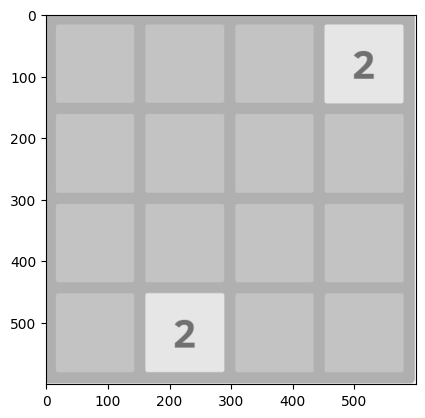

In [4]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [5]:
done, done_cap = env.get_done()

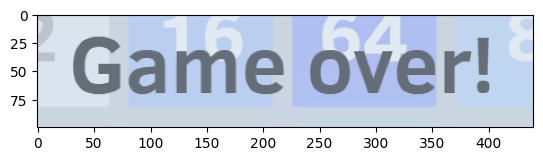

In [6]:
plt.imshow(done_cap)

In [7]:
pytesseract.image_to_string(done_cap)[:4]

'Game'

In [8]:
done

True

In [54]:
for episode in range(5): 
    obs = env.reset()
    done = False  
    total_reward = 0
    while not done:
        obs, reward, done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

2
2
-4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
-4
2
-4
-16
2
2
2
2
2
2
2
2
-4
2
2
-4
2
2
2


KeyboardInterrupt: 

In [10]:
env_checker.check_env(env)

In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [6]:
callback = TrainAndLoggingCallback(check_freq=2000, save_path=CHECKPOINT_DIR)

In [7]:
# model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1, learning_starts=1000)
model = PPO("CnnPolicy", env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0003, n_steps=128, n_epochs=5, clip_range=0.2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=40000, callback=callback)
model.save("2048_40000_steps")

Logging to ./logs/PPO_1
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 45        |
|    ep_rew_mean     | -6.58e+04 |
| time/              |           |
|    fps             | 0         |
|    iterations      | 1         |
|    time_elapsed    | 156       |
|    total_timesteps | 128       |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 85         |
|    ep_rew_mean          | -6.6e+04   |
| time/                   |            |
|    fps                  | 0          |
|    iterations           | 2          |
|    time_elapsed         | 716        |
|    total_timesteps      | 256        |
| train/                  |            |
|    approx_kl            | 0.39274713 |
|    clip_fraction        | 0.553      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 6.56e-07   |
|    learni

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |
| time/                   |           |
|    fps                  | 0         |
|    iterations           | 12        |
|    time_elapsed         | 6268      |
|    total_timesteps      | 1536      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.47e-10 |
|    explained_variance   | -6.48     |
|    learning_rate        | 0.0003    |
|    loss                 | 3.21e+06  |
|    n_updates            | 55        |
|    policy_gradient_loss | 1.73e-08  |
|    value_loss           | 2.95e+06  |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |
| time/                   |           |
|    fps                  | 0         |
|    iterations           | 22        |
|    time_elapsed         | 11877     |
|    total_timesteps      | 2816      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.65e-13 |
|    explained_variance   | 0.289     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.41e+06  |
|    n_updates            | 105       |
|    policy_gradient_loss | -1.51e-08 |
|    value_loss           | 1.38e+06  |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |
| time/                   |           |
|    fps                  | 0         |
|    iterations           | 32        |
|    time_elapsed         | 17563     |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.35e-13 |
|    explained_variance   | 0.482     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.33e+06  |
|    n_updates            | 155       |
|    policy_gradient_loss | 2.1e-08   |
|    value_loss           | 9.63e+05  |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |
| time/                   |           |
|    fps                  | 0         |
|    iterations           | 42        |
|    time_elapsed         | 23291     |
|    total_timesteps      | 5376      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.6e-13  |
|    explained_variance   | 0.563     |
|    learning_rate        | 0.0003    |
|    loss                 | 5.63e+05  |
|    n_updates            | 205       |
|    policy_gradient_loss | 5.45e-09  |
|    value_loss           | 6.58e+05  |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | -6.58e+04 |
| time/                   |           |
|    fps                  | 0         |
|    iterations           | 52        |
|    time_elapsed         | 28908     |
|    total_timesteps      | 6656      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.83e-11 |
|    explained_variance   | -2.12     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.27e+05  |
|    n_updates            | 255       |
|    policy_gradient_loss | 1.86e-10  |
|    value_loss           | 2.4e+06   |
---------------------------------------


In [16]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info =  env.step(int(action))
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

Total Reward for episode 0 is -65812
Total Reward for episode 1 is -65812
Total Reward for episode 2 is -65812
Total Reward for episode 3 is -65812
Total Reward for episode 4 is -65812


In [81]:
env.close()